# Race for the Galaxy AI
* Ref: [Game Architecture for Card Game AI (Part 3)](http://bennycheung.github.io/game-architecture-card-ai-3)

## Installation
The following Python modules are required to run this notebook.

```
pip install keras==2.4.3
pip install tensorflow==2.5.0
pip install pydot
```

In addition, we need to define the `.keras/keras.json` to use the tensorflow backend.

```json
 {
  "image_data_format": "channels_last",
  "epsilon": 1e-07,
  "floatx": "float32",
  "backend": "tensorflow"
}
```

## <a name="GameState"></a> Game State
The game state can represent any information available to the decision-maker, that is useful to describe the current situation of the game.  This could be the type of cards a player holds, the number of cards the opponent holds, or information regarding cards that have already been played. Without a doubt, RFTG is a complex card game, due to its elaborate set of rules and phases of action.

By reading the list of input node names, we can understand the game states are fed into the network. The game state can be,

* Game over
* VP Pool size
* Max active cards
* Type of cards at hand
* The number of cards at hand
* Player number of goods
* Opponent number of goods
* etc.

The list can go from *700s* for a game of 2 players up to *1,800s* for a game of 5 players (using expansion=6).

## <a name="NeuralNetwork"></a> Neural Networks
These inputs don’t just feed into one neural network. According to Keldon's code, he got twelve unique models of neural networks each trained for a different set of expansions and player count. If we're running a two-player game, the AI is on a different network than a three-player game. For each game model, there are two flavours of neural networks at work, each with its main function.

For example,
* Eval Network - file for `eval` weights for expansion 0 (base game) 2 (players) `rftg.eval.0.2.net`
* Role Network - file for `role` weights for expansion 0 (base game) 2 (players) `rftg.role.0.2.net`

Both network weights file format are the same; the contents are varying with,
* Input size, hidden layer size, output layer size
  * For example `rftg.eval.0.2.net` : (704, 50, 2)
  * For example `rftg.role.0.2.net` : (605, 50, 7)
* Number of training iterations
* The list of input node names
* The weights for each layer nodes

In [1]:
import numpy as np

# RFTG Network Loader
class Network:

	def __init__(self):
		pass

	def network_name(self, network, expansion, players, advanced=False):
		network_name = "rftg.%s.%d.%d%s.net" %(network, expansion, players, ("a" if advanced else ""))
		return network_name

	def load_net(self, network, expansion, players, advanced=False):
		self.network = network
		self.expansion = expansion
		self.players = players
		self.advanced = advanced
		self.network_name = self.network_name(network, expansion, players, advanced)

		filename = 'network/{}'.format(self.network_name)
		fp = open(filename)
		# read network layers size
		(input, hidden, output) = fp.readline().strip().split(' ')
		print(input, hidden, output)
		# read number of training iterations
		training = fp.readline().strip()

		self.num_input = int(input)
		self.num_hidden = int(hidden)
		self.num_output = int(output)

		# read input names
		self.input_names = []
		for i in range(0, self.num_input):
			name = fp.readline().strip()
			self.input_names.append(name)

		self.input = np.zeros(shape=(self.num_input, 1))
		print('Input Layer: ', self.input.shape)

		# read hidden nodes
		self.hidden = np.ndarray(shape=(self.num_input, self.num_hidden))
		for r in range(0, self.num_hidden):
			for c in range(0, self.num_input):
				self.hidden[c, r] = float(fp.readline().strip())
		print('Hidden Layer: ', self.hidden.shape)

		# read output nodes
		self.output = np.ndarray(shape=(self.num_hidden, self.num_output))
		for r in range(0, self.num_output):
			for c in range(0, self.num_hidden):
				self.output[c, r] = float(fp.readline().strip())
		print('Output Layer: ', self.output.shape)

		# all done
		fp.close()


In [2]:
# reading `role` network of expansion 0 with 2 players, not advanced game
network = Network()
network.load_net('role', 0, 2)

605 50 7
Input Layer:  (605, 1)
Hidden Layer:  (605, 50)
Output Layer:  (50, 7)


## Deep Neural Network using Keras

We’re using Keras to redefine the RFTG neural network. Although it may feel overkill, this illustrate how to use the more powerful deep neural network toolkit such that we can potential extend the network ability. A Keras layer that will only accept as input 2D tensors where the first dimension is the network input size, e.g. 605 (axis 0, the batch dimension, is unspecified, and thus any value would be accepted). This layer will return a tensor where the first dimension has been transformed to be 50. Thus this layer can only be connected to a downstream layer that expects 50-dimensional vectors as its input.

The second layer didn’t receive an input shape argument—instead, it automatically inferred its input shape as being the output shape of the layer that came before.

The last layer uses a `softmax` activation. It means the network will output a probability distribution over the 7 different output classes—for every input sample, the network will produce a 7-dimensional output vector, where output[i] is the probability that the sample belongs to class i (i.e. role choice). The 7 scores will sum to 1.

The summary can be created by calling the summary() function on the model that returns a string that in turn can be printed.


In [3]:
from keras import models
from keras import layers

model = models.Sequential(name=network.network_name)
# input layer
# implicit in the input_shape data
# hidden layer
model.add(layers.Dense(50, activation='relu', input_shape=(network.num_input,), name='hidden'))
# output layer
model.add(layers.Dense(7, activation='softmax', name='output') )

# model summary can be printed.
model.summary()

Model: "rftg.role.0.2.net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 50)                30300     
_________________________________________________________________
output (Dense)               (None, 7)                 357       
Total params: 30,657
Trainable params: 30,657
Non-trainable params: 0
_________________________________________________________________


### Visualize Model
The summary is useful for simple models, but can be confusing for models that have multiple inputs or outputs. Keras also provides a function to create a plot of the network neural network graph that can make more complex models easier to understand.

The plot_model() function in Keras will create a plot of your network. 

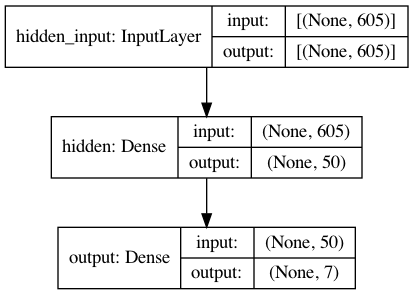

In [4]:
from keras.utils.vis_utils import plot_model

plot_filename='{}.png'.format(network.network_name)
plot_model(model, to_file=plot_filename, show_shapes=True, show_layer_names=True)

In [5]:
hidden_layer = model.get_layer('hidden')
output_layer = model.get_layer('output')
print('Hidden Layer:', hidden_layer.input_shape, hidden_layer.output_shape)
print('Output Layer:', output_layer.input_shape, output_layer.output_shape)

Hidden Layer: (None, 605) (None, 50)
Output Layer: (None, 50) (None, 7)


### Loading Network Weights into Layers
We have load the RFTG `role` network weights. After defining the Keras deep neural network, we can assign the weights into the corresponding layers
* network.hidden -> hidden_layer
* network.output -> output_layer


In [6]:
hidden_layer.set_weights([network.hidden, np.zeros(shape=hidden_layer.output_shape[1])])
output_layer.set_weights([network.output, np.zeros(shape=output_layer.output_shape[1])])

In [7]:
hidden_layer.get_weights()

[array([[ 0.02684849, -0.07043163,  0.17830057, ...,  0.08084569,
         -0.09834311,  0.3189879 ],
        [ 0.03219581,  0.06759464, -0.08408735, ...,  0.08180485,
          0.12012478,  0.03991435],
        [-0.07090639, -0.01249493,  0.05813789, ...,  0.04127461,
          0.0998257 , -0.01798295],
        ...,
        [-0.8491952 , -0.30811298, -0.12133851, ...,  0.01339607,
         -0.10589286,  0.00837689],
        [ 1.2423377 , -0.0644151 ,  0.24686392, ...,  0.06034593,
          0.04830525,  0.00200542],
        [-0.5312858 ,  0.17594491,  0.3015494 , ..., -0.10620899,
         -0.03211459, -0.07428143]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)]

### Using Neural Network for Predictions (Scores)

After the network weights are loaded, we can verify that the `predict` method of the model instance returns a probability distribution over all 7 topics.

Let’s generate a random set of game state as the test input data.

In [15]:
random_input = np.random.randint(2, size=hidden_layer.input_shape[1])
x_input = np.array([random_input])
x_input


array([[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 

We actually don't know what this random game state vector meant. Mostly likely a random game state will make no sense. Just for interest, we can print the network input names to check. Those input names are loaded from the RFTG's network file.


In [ ]:
# for i in range(0, len(random_input)):
#  if random_input[i] == 1:
#    print('{}'.format(network.input_names[i]))
 

In this test, we actually don't know what does the set of game states meant. We are just interest to know the neural network will use the network weights to score the output predictions (aka. choices).


In [17]:
predictions = model.predict(x_input)
predictions

array([[0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In this example, we can see the output shape is 7. The total probability should be summed to 1 and the maximum score is choice index 2 (which is 3).

In [10]:
predictions[0].shape

(7,)

In [85]:
np.sum(predictions[0])

1.0

In [86]:
np.argmax(predictions[0])

2